<a href="https://colab.research.google.com/github/annadelpozo/MDL-Turing/blob/main/MDL_project_Final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

#Shape inflation and hapinness data
Add the columns from inflation dataset to the hapiness dataset to create our dataframe.
Some country names were different in both datasets so we fixed this manually.
We drop datapoints with no inflation recorded.

In [2]:
inflation = pd.read_csv("/content/global_inflation_data.csv")

inflation.drop(columns = "indicator_name", inplace = True)
for i in inflation.columns[1:]:
  if int(i) < 2015 or int(i) == 2024:
    inflation.drop(columns = i, inplace = True)

data = pd.read_csv("/content/WHI_Inflation 2.csv")
data["Inflation"] = np.nan

name_country_data = ["China", "North Macedonia", "South Sudan", "Swaziland", "Slovakia", "Turkey"]
name_country_infl = ["China, People's Republic of","North Macedonia ","South Sudan, Republic of", "Eswatini", "Slovak Republic","Türkiye, Republic of"]

inflation['country_name'] = inflation['country_name'].replace(name_country_infl, name_country_data)

for index_inf, country_inf in enumerate(inflation["country_name"]):
  for index_data, country_data in enumerate(data["Country"]):
    if country_inf == country_data and (str(data['Year'][index_data]) in inflation.columns[1:]):
      data['Inflation'][index_data]=inflation[str(data['Year'][index_data])][index_inf]

print(data.shape)
data.dropna(subset= "Inflation", inplace = True)
print(data.shape)
data.head(20)

(1232, 17)
(1228, 17)


,Country,Year,Headline Consumer Price Inflation,Energy Consumer Price Inflation,Food Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,GDP deflator Index growth rate,Continent/Region,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Inflation
0,Afghanistan,2015,-0.660000,-4.250000,-0.840000,0.219999,NaN,2.665090,South Asia,3.5750,0.319820,0.302850,0.303350,0.234140,0.365100,0.097190,-0.66
1,Afghanistan,2016,4.380000,2.070000,5.670000,5.192760,NaN,-2.409509,South Asia,3.3600,0.382270,0.110370,0.173440,0.164300,0.312680,0.071120,4.38
2,Afghanistan,2017,4.976000,4.440000,6.940000,5.423228,NaN,2.404000,South Asia,3.7940,0.401477,0.581543,0.180747,0.106180,0.311871,0.061158,4.98
3,Afghanistan,2018,0.630000,1.474185,-1.045952,-0.126033,NaN,2.071208,South Asia,3.6320,0.332000,0.537000,0.255000,0.085000,0.191000,0.036000,0.63
4,Afghanistan,2019,2.302000,-2.494359,3.794770,NaN,NaN,6.520928,South Asia,3.2030,0.350000,0.517000,0.361000,0.000000,0.158000,0.025000,2.30
5,Afghanistan,2020,5.443000,NaN,5.829005,NaN,NaN,5.307120,South Asia,2.5669,0.300706,0.356434,0.266052,0.000000,0.135235,0.001226,5.44
6,Afghanistan,2021,5.062000,NaN,NaN,NaN,NaN,0.524517,South Asia,2.5230,0.370000,0.000000,0.126000,0.000000,0.122000,0.010000,5.06
7,Afghanistan,2022,10.600000,NaN,NaN,NaN,NaN,5.475071,South Asia,2.4040,0.758000,0.000000,0.289000,0.000000,0.089000,0.005000,13.71
8,Afghanistan,2023,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,1.8590,0.645000,0.000000,0.087000,0.000000,0.093000,0.059000,9.10
9,Albania,2015,1.910179,-0.520000,4.319489,-0.156957,NaN,0.564278,Central and Eastern Europe,4.9590,0.878670,0.804340,0.813250,0.357330,0.142720,0.064130,1.90


#Check correlations in our data
We will remove variables with multicollinearity risks, and check to see if the direction of impact on our dependant variable inflation is as expected.

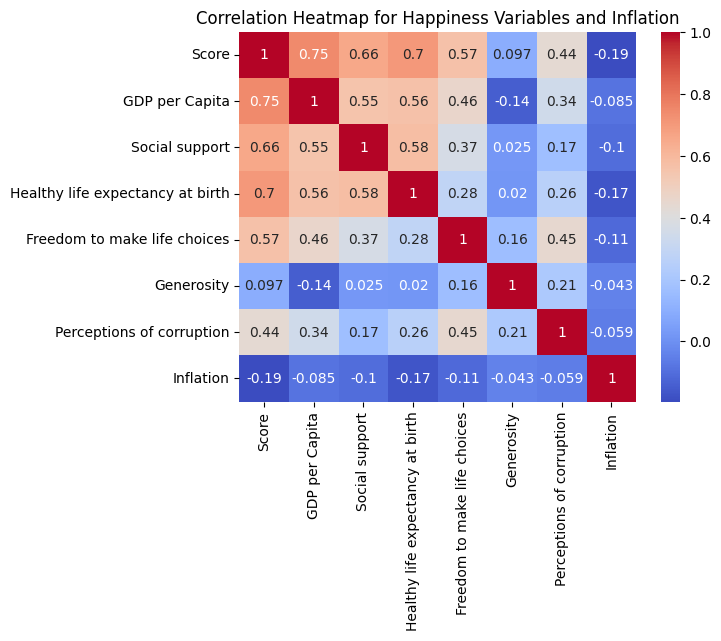

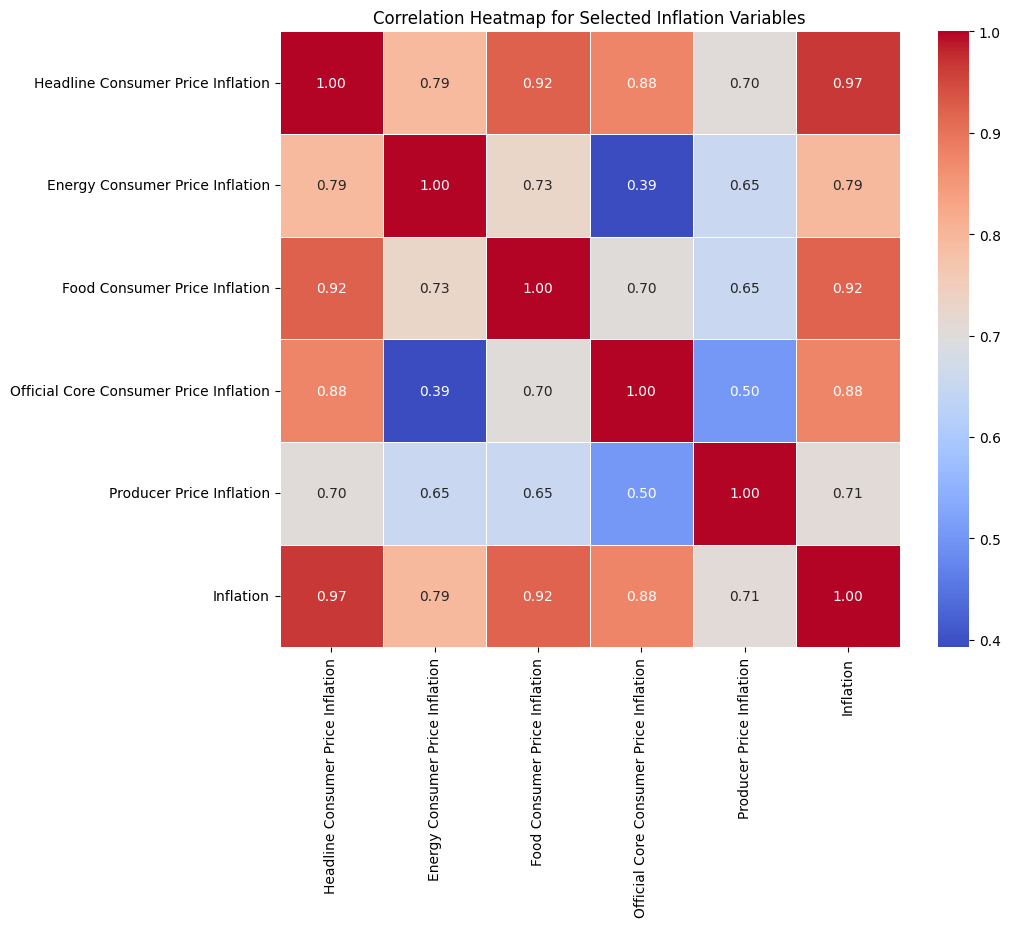

In [3]:
corr_matrix_happy = data.iloc[:,9:17].corr()
sns.heatmap(corr_matrix_happy, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for Happiness Variables and Inflation")
plt.show()

columns_to_select = list(range(2, 7)) + [16]

# Select the columns using their index and name from the DataFrame
numeric_columns_infl = data.iloc[:, columns_to_select]  # Use .iloc for integer-location based indexing

# Calculate the correlation matrix for the selected columns
corr_matrix_infl = numeric_columns_infl.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_infl, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Selected Inflation Variables")
plt.show()

# Lagging the variables + Add Binary Inflation
Goal: include 1 year lags as this empirically makes sense, for each type of inflation.

We also use this code to define our binary variable: 1 if inflation increased from year before, 0 if it decreased.

In [4]:
lagged_variables = ["Energy Consumer Price Inflation", "Food Consumer Price Inflation", "Official Core Consumer Price Inflation", "Producer Price Inflation"]
lagged_names = ["Energy_CPI_lag1", "Food_CPI_lag1", "Official_Core_CPI_lag1", "Producer_price_inflation_lag1"]
for country in data["Country"].unique():
  data.loc[data['Country'] == country, lagged_variables] = data.loc[data['Country'] == country, lagged_variables].shift(1)
  data.loc[data['Country']==country, "Inflation_Binary"] = (data["Inflation"] > data["Inflation"].shift(1)).astype(int)
data = data.rename(columns=dict(zip(lagged_variables, lagged_names)))

data.head(10)


,Country,Year,Headline Consumer Price Inflation,Energy_CPI_lag1,Food_CPI_lag1,Official_Core_CPI_lag1,Producer_price_inflation_lag1,GDP deflator Index growth rate,Continent/Region,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Inflation,Inflation_Binary
0,Afghanistan,2015,-0.660000,NaN,NaN,NaN,NaN,2.665090,South Asia,3.5750,0.319820,0.302850,0.303350,0.23414,0.365100,0.097190,-0.66,0.0
1,Afghanistan,2016,4.380000,-4.250000,-0.840000,0.219999,NaN,-2.409509,South Asia,3.3600,0.382270,0.110370,0.173440,0.16430,0.312680,0.071120,4.38,1.0
2,Afghanistan,2017,4.976000,2.070000,5.670000,5.192760,NaN,2.404000,South Asia,3.7940,0.401477,0.581543,0.180747,0.10618,0.311871,0.061158,4.98,1.0
3,Afghanistan,2018,0.630000,4.440000,6.940000,5.423228,NaN,2.071208,South Asia,3.6320,0.332000,0.537000,0.255000,0.08500,0.191000,0.036000,0.63,0.0
4,Afghanistan,2019,2.302000,1.474185,-1.045952,-0.126033,NaN,6.520928,South Asia,3.2030,0.350000,0.517000,0.361000,0.00000,0.158000,0.025000,2.30,1.0
5,Afghanistan,2020,5.443000,-2.494359,3.794770,NaN,NaN,5.307120,South Asia,2.5669,0.300706,0.356434,0.266052,0.00000,0.135235,0.001226,5.44,1.0
6,Afghanistan,2021,5.062000,NaN,5.829005,NaN,NaN,0.524517,South Asia,2.5230,0.370000,0.000000,0.126000,0.00000,0.122000,0.010000,5.06,0.0
7,Afghanistan,2022,10.600000,NaN,NaN,NaN,NaN,5.475071,South Asia,2.4040,0.758000,0.000000,0.289000,0.00000,0.089000,0.005000,13.71,1.0
8,Afghanistan,2023,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,1.8590,0.645000,0.000000,0.087000,0.00000,0.093000,0.059000,9.10,0.0
9,Albania,2015,1.910179,NaN,NaN,NaN,NaN,0.564278,Central and Eastern Europe,4.9590,0.878670,0.804340,0.813250,0.35733,0.142720,0.064130,1.90,0.0


Now check the new correlation matrix for the inflation lags:

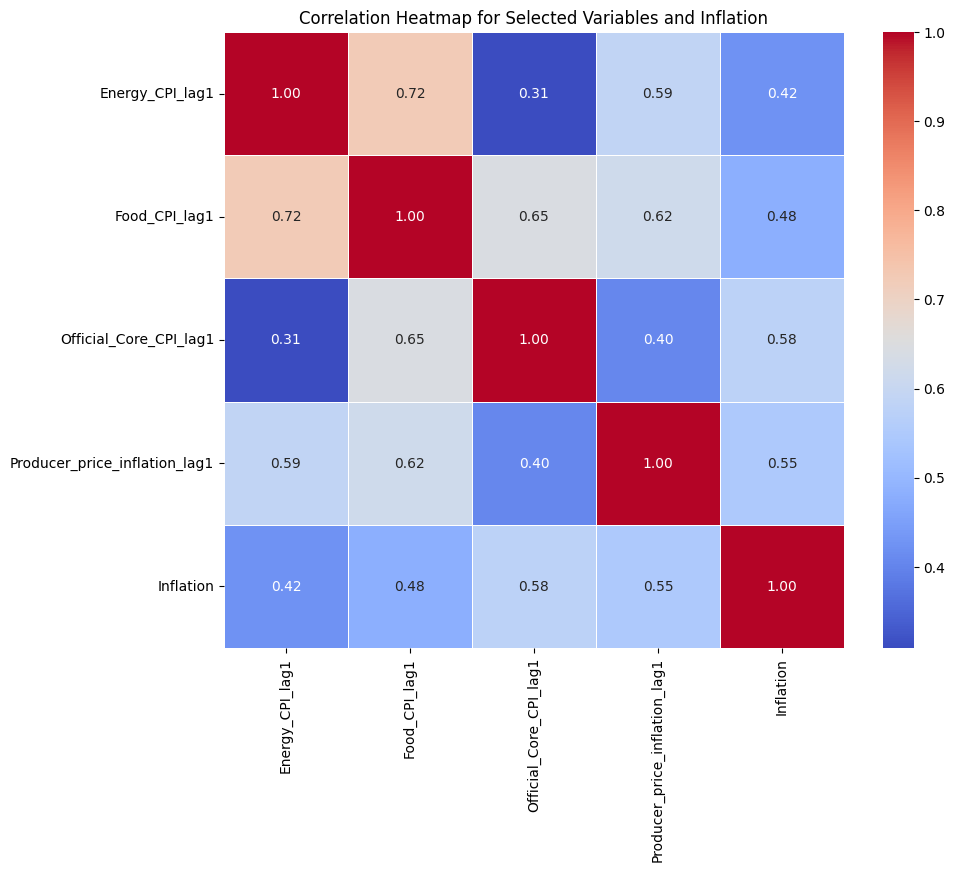

In [5]:
columns_to_select = list(range(3, 7)) + [16]

# Select the columns using their index and name from the DataFrame
numeric_columns_infl = data.iloc[:, columns_to_select]  # Use .iloc for integer-location based indexing

# Calculate the correlation matrix for the selected columns
corr_matrix_infl = numeric_columns_infl.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_infl, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Selected Variables and Inflation")
plt.show()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 0 to 1231
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country                            1228 non-null   object 
 1   Year                               1228 non-null   int64  
 2   Headline Consumer Price Inflation  1196 non-null   float64
 3   Energy_CPI_lag1                    972 non-null    float64
 4   Food_CPI_lag1                      1001 non-null   float64
 5   Official_Core_CPI_lag1             653 non-null    float64
 6   Producer_price_inflation_lag1      704 non-null    float64
 7   GDP deflator Index growth rate     1208 non-null   float64
 8   Continent/Region                   1228 non-null   object 
 9   Score                              1228 non-null   float64
 10  GDP per Capita                     1228 non-null   float64
 11  Social support                     1228 non-null   float64
 1

#Drop things
Drop columns with missing values (producer and official cpi)

Drop problematic countries with shocks that cause outlier inflation values (this will only bias our model, especially if we do not include country effects).

Drop all remaining NaN rows

Also: create df_encoded and encode by country as a method of including country effects

In [7]:
data.drop(columns = ["GDP deflator Index growth rate", "Headline Consumer Price Inflation", "Continent/Region", "Producer_price_inflation_lag1", "Official_Core_CPI_lag1","Year"], inplace = True)
data.dropna(inplace = True)

countries_to_drop = ["Zimbabwe", "Lebanon", "Argentina","Turkey"]
data = data[~data["Country"].isin(countries_to_drop)]

data.drop(columns=["Country"], inplace = True)
print(data.shape)

(937, 11)


#Random forrest on inflation binary
1. define X train, test and y train, test

In [33]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation_Binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(749, 9) (188, 9) (749,) (188,)


#We did a grid search for the parameters

#Forests for Binary inflation using the best parameters

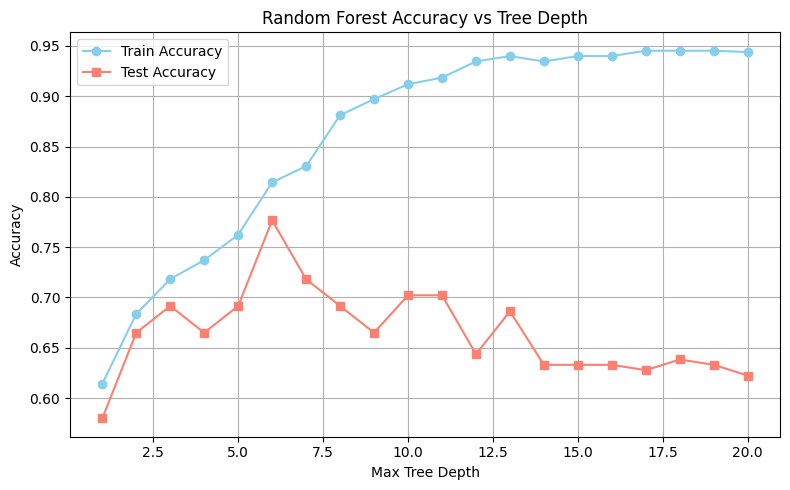

In [42]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

depths = list(range(1, 21))  # Try depths from 1 to 20
train_accuracies = []
test_accuracies = []

for depth in depths:
    model = RandomForestClassifier(
        n_estimators=6,
        max_depth=depth,
        min_samples_leaf=2,
        min_samples_split=3,
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='skyblue')
plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='salmon')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

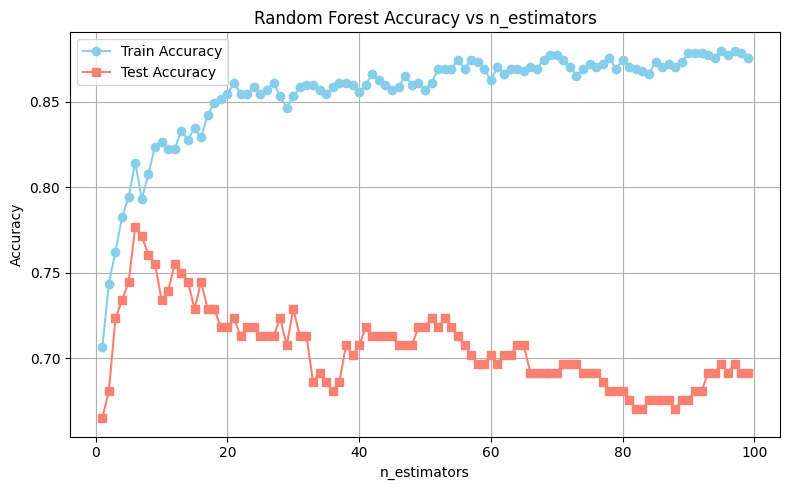

In [41]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estim = list(range(1, 100))  # Try depths from 1 to 20
train_accuracies = []
test_accuracies = []

for estimator in estim:
    model = RandomForestClassifier(
        n_estimators=estimator,
        max_depth=6,
        min_samples_leaf=2,
        min_samples_split=3,
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(estim, train_accuracies, marker='o', label='Train Accuracy', color='skyblue')
plt.plot(estim, test_accuracies, marker='s', label='Test Accuracy', color='salmon')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
from sklearn.ensemble import RandomForestClassifier as RFC

#Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 30}
modelRFC = RFC(n_estimators=6, max_depth=6, min_samples_leaf = 2, max_features = "sqrt", min_samples_split = 3, random_state=42)
modelRFC.fit(X_train, y_train)

print("Random Forest binary")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFC, X_train, y_train, X_test, y_test)

Random Forest binary
Training score: 0.8144192256341789
Testing score:  0.776595744680851


Number of times infl_bin is 1: 510 out of 937 observations


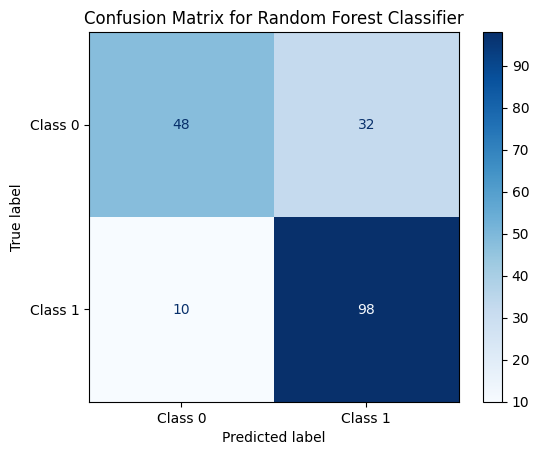

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

count_ones = (data['Inflation_Binary'] == 1).sum()
total_rows = len(data)
print(f"Number of times infl_bin is 1: {count_ones} out of {total_rows} observations")

# Generate and plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    modelRFC,
    X_test,
    y_test,
    display_labels=['Class 0', 'Class 1'],  # Replace with your actual class names if different
    cmap=plt.cm.Blues,
    normalize=None
)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

What if we drop the inflation lags?

In [53]:
X_2 = data.drop(columns = ["Inflation", "Inflation_Binary","Energy_CPI_lag1","Food_CPI_lag1"])
y_2 = data["Inflation_Binary"]
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
print(X_2_train.shape, X_2_test.shape, y_2_train.shape, y_2_test.shape)

modelRFC2 = RFC(n_estimators=6, max_depth=6, min_samples_leaf = 2, max_features = "sqrt", min_samples_split = 3, random_state=42)
modelRFC2.fit(X_2_train, y_2_train)

print("Random Forest binary")

get_accuracies(modelRFC2, X_2_train, y_2_train, X_2_test, y_2_test)

(749, 7) (188, 7) (749,) (188,)
Random Forest binary
Training score: 0.7863818424566088
Testing score:  0.6063829787234043


Feature importance

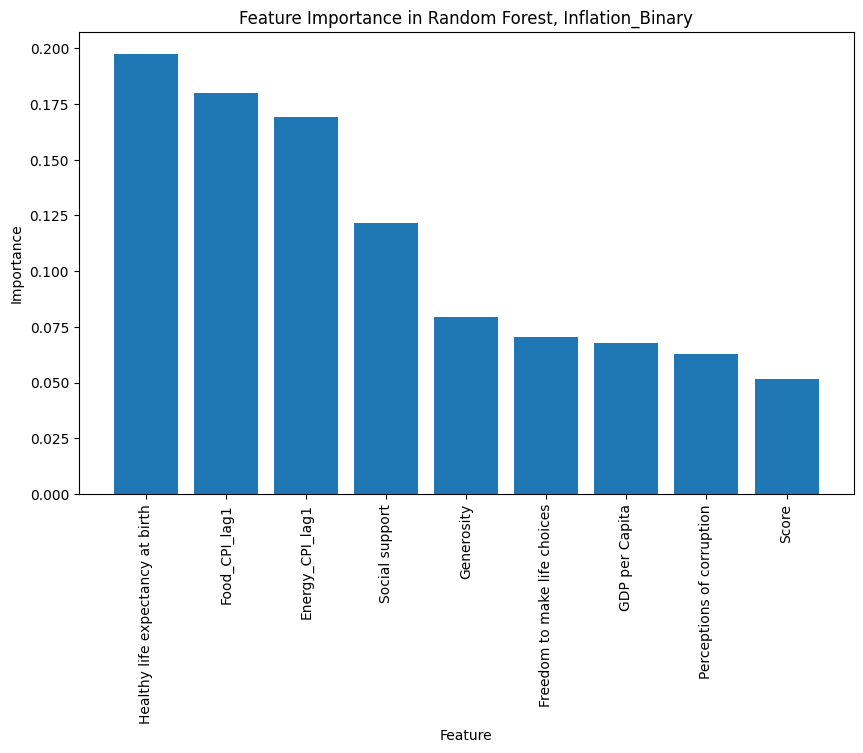

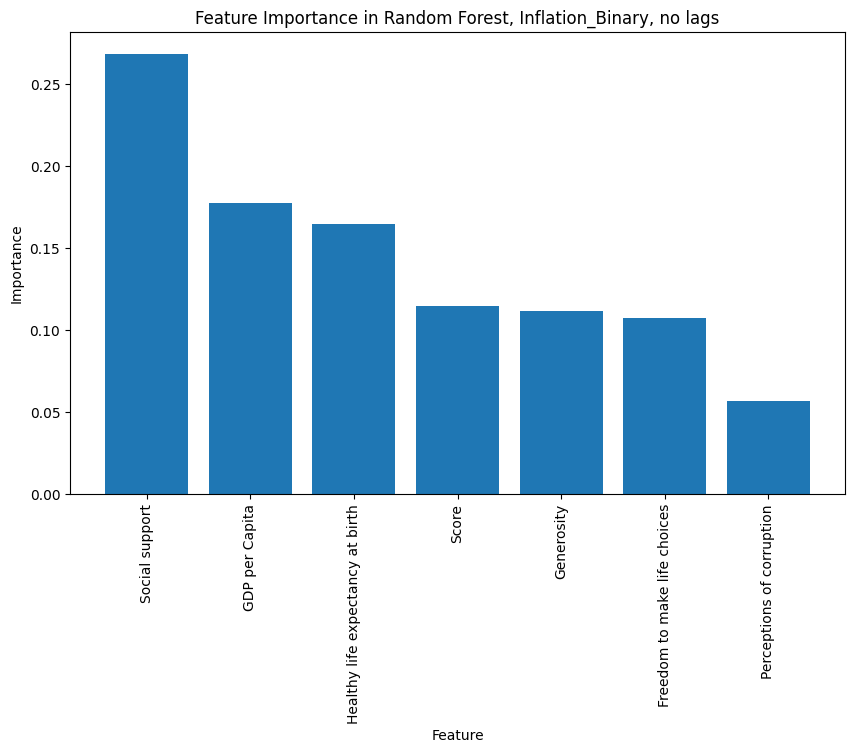

In [45]:
feature_importances = modelRFC.feature_importances_
feature_names = X_train.columns  # Ensure train_X is a DataFrame

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest, Inflation_Binary")
plt.show()

feature_importances = modelRFC2.feature_importances_
feature_names = X_2_train.columns  # Ensure train_X is a DataFrame

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest, Inflation_Binary, no lags")
plt.show()

#Random forests to predict the inflation (continuous)


First define new X, y train and test

In [54]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(749, 9) (188, 9) (749,) (188,)


#We ran a grid search and use the best parameters

#Continuous Inflation forest using best params

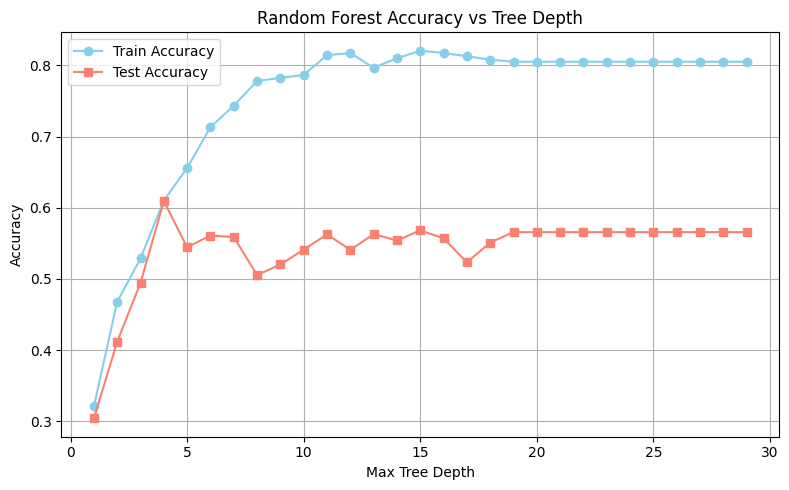

In [60]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

depths = list(range(1, 30))  # Try depths from 1 to 20
train_accuracies = []
test_accuracies = []

for depth in depths:
    model = RandomForestRegressor(
        n_estimators=9,
        max_depth=depth,
        min_samples_leaf=2,
        min_samples_split=3,
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='skyblue')
plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='salmon')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

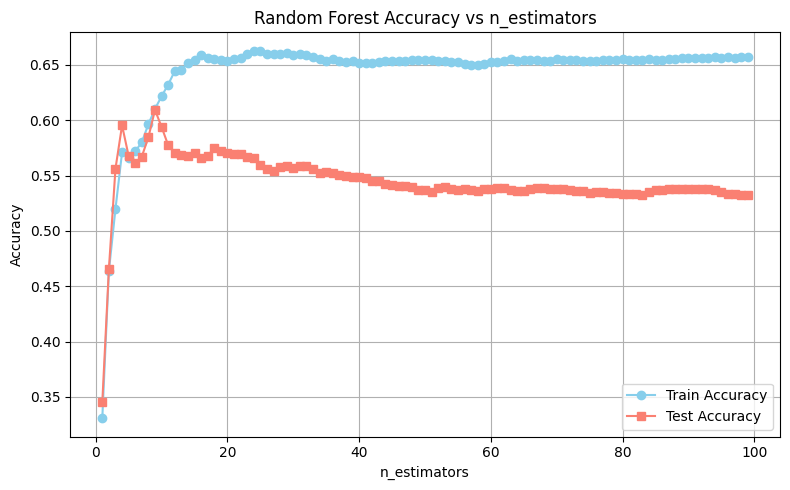

In [59]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

estim = list(range(1, 100))  # Try depths from 1 to 20
train_accuracies = []
test_accuracies = []

for estimator in estim:
    model = RandomForestRegressor(
        n_estimators=estimator,
        max_depth=4,
        min_samples_leaf=2,
        min_samples_split=3,
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(estim, train_accuracies, marker='o', label='Train Accuracy', color='skyblue')
plt.plot(estim, test_accuracies, marker='s', label='Test Accuracy', color='salmon')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
from sklearn.ensemble import RandomForestRegressor as RFR

modelRFR = RFR(n_estimators=9, max_depth=4, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5 ,random_state=42)
modelRFR.fit(X_train, y_train)

print("Random Forest")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFR, X_train, y_train, X_test, y_test)

Random Forest
Training score: 0.6101213603635061
Testing score:  0.6092014695440837


#Plot predicted vs true values for normal and encoded data

     True Values  Predictions
393          1.9     1.541907
96           4.9     6.245328
265          1.6     2.186267
820         -2.5     6.055836
863          0.7     2.216044
126          2.8     4.547496
561          8.0     6.855496
115          1.8     2.862326
666          1.0     3.358222
400         17.5    13.296536


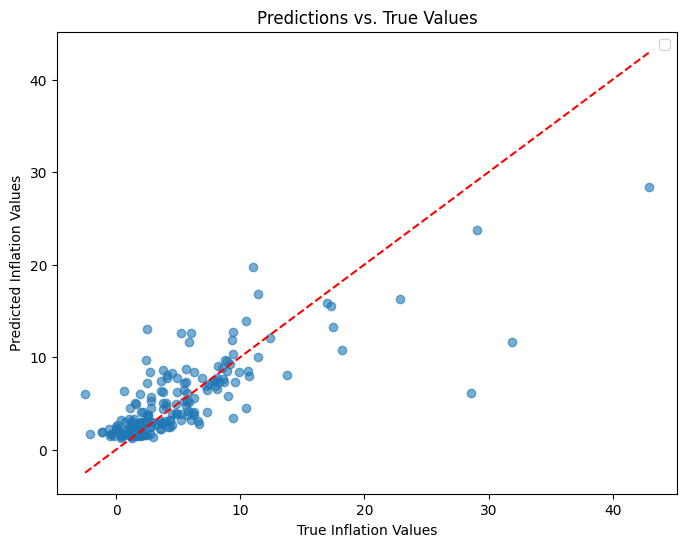

In [62]:
pred_y = modelRFR.predict(X_test)
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({"True Values": y_test, "Predictions": pred_y})
print(comparison_df.head(10))

plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_y, alpha=0.6)
plt.xlabel("True Inflation Values")
plt.ylabel("Predicted Inflation Values")
plt.title("Predictions vs. True Values")
plt.legend()
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # 45-degree reference line
plt.show()

#And feature importance:

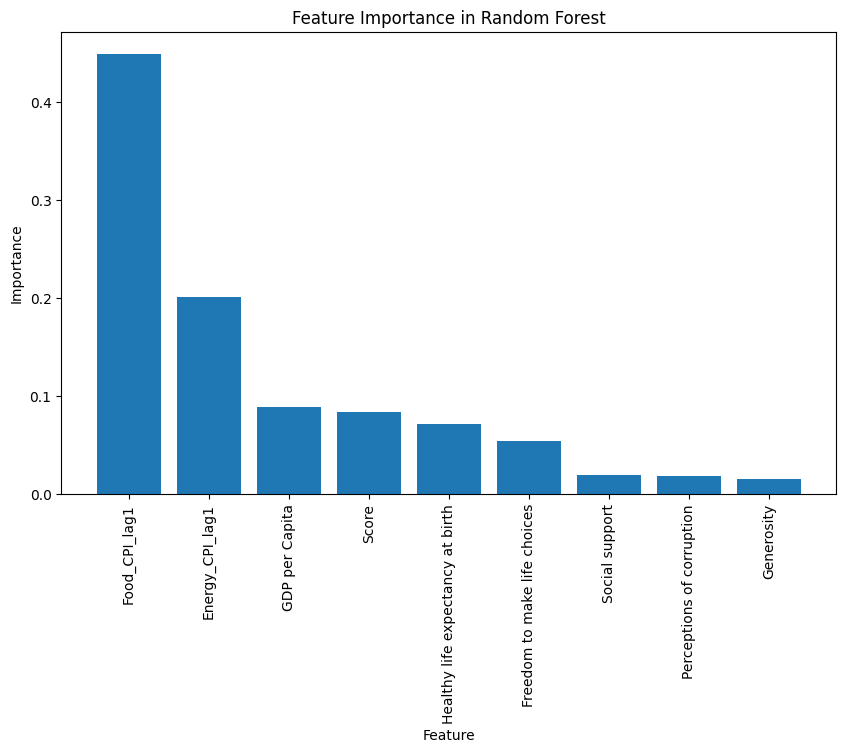

In [63]:
feature_importances = modelRFR.feature_importances_
feature_names = X_train.columns  # Ensure train_X is a DataFrame

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

#Can an SVM  work better?

1) On inflation binary
Note: we use metric accuracy for classification

In [64]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation_Binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(749, 9) (188, 9) (749,) (188,)


In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
param_grid_svc = {
    'kernel': ['linear', 'rbf'],  # Kernel types to be tested
    'C': [0.1, 1, 10],                   # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1]  # Kernel coefficient for 'rbf' and 'poly'
}
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Optimize for accuracy
    verbose=1,
    n_jobs=-1           # Use all available CPU cores
)
grid_search_svc.fit(X_train, y_train)
best_svc = grid_search_svc.best_estimator_
print("Best parameters:", grid_search_svc.best_params_)
print("Best accuracy:", grid_search_svc.best_score_)
y_pred = best_svc.predict(X_test)

# Calculate accuracy
print("Inflation Binary SVM:")
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 0.6528322147651007
Inflation Binary SVM:
Test Set Accuracy: 0.6648936170212766


Number of times infl_bin is 1: 510 out of 937 observations


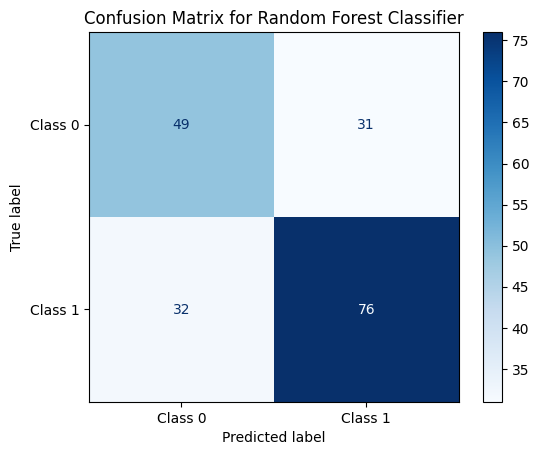

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

count_ones = (data['Inflation_Binary'] == 1).sum()
total_rows = len(data)
print(f"Number of times infl_bin is 1: {count_ones} out of {total_rows} observations")

# Generate and plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_svc,
    X_test,
    y_test,
    display_labels=['Class 0', 'Class 1'],  # Replace with your actual class names if different
    cmap=plt.cm.Blues,
    normalize=None
)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

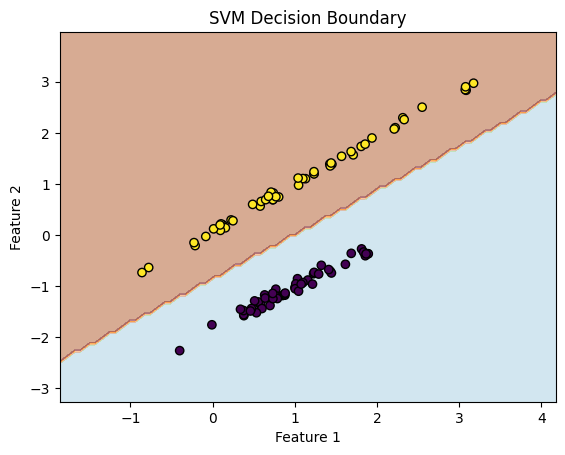

In [19]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.inspection import DecisionBoundaryDisplay

# Generate synthetic data
X, y = make_classification(n_samples=100,   # Increased number of samples
                           n_features=2,    # Total number of features
                           n_informative=2, # Number of informative features
                           n_redundant=0,   # No redundant features
                           n_clusters_per_class=1,
                           random_state=42)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X, y)

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", cmap=plt.cm.Paired, alpha=0.5)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
disp.ax_.set_xlabel('Feature 1')
disp.ax_.set_ylabel('Feature 2')
disp.ax_.set_title('SVM Decision Boundary')
plt.show()

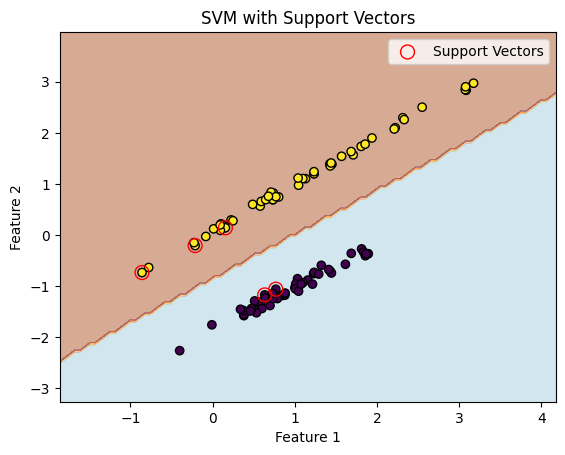

In [20]:
support_vectors = clf.support_vectors_

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none', edgecolors='r', s=100, label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with Support Vectors')
plt.legend()
plt.show()

2) on inflation (continuous so we use regressor):
Note: we use metric MAE (mean absolute error) for continuous data

In [21]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(749, 9) (188, 9) (749,) (188,)


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grid
param_grid_svm = {
    'kernel': ['linear', 'rbf'],  # Different kernel functions
    'C': [0.1, 1, 10],  # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
}

# Create the GridSearchCV object
optimal_params_svm = GridSearchCV(
    estimator=SVR(),            # Support Vector Regression model
    param_grid=param_grid_svm,  # Hyperparameter grid
    cv=5,                       # 5-fold cross-validation
    scoring=mae_scorer,
    verbose=1,                  # Show progress
    n_jobs=-1                   # Use all CPU cores
)

# Fit the model
optimal_params_svm.fit(X_train, y_train)
best_svm = optimal_params_svm.best_estimator_

# Print best parameters and score
print("Inflation SVM")
print("Best parameters:", optimal_params_svm.best_params_)
print(get_accuracies(best_svm,X_train,y_train,X_test,y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Inflation SVM
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Training score: 0.5144169006248845
Testing score:  0.49235437108041347
None


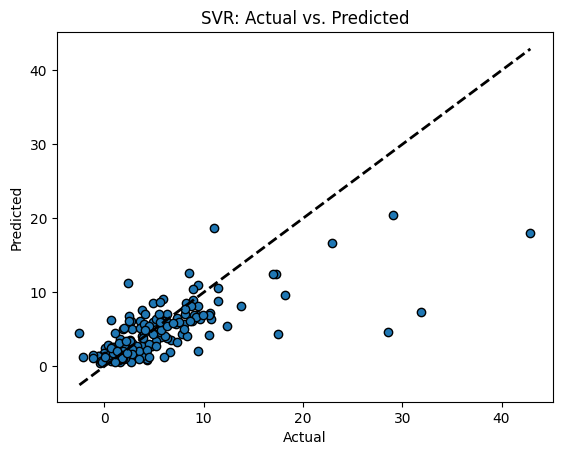

In [23]:
import matplotlib.pyplot as plt

# Predict on test data
y_pred = optimal_params_svm.predict(X_test)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Actual vs. Predicted')
plt.show()

#Weaknesses / Takeaways
1) Not making use of panel data (also due to insufficient dataset)

2) Not including country specific effects

3) Are our hapiness data interlinked?

5) For future research maybe include more macroeconomic variables (for higher precision) and include our best finding - Healthy life expectancy at birth.

4) Promising preleminary glance at effects between hapiness index and inflation fro future research / better dataset - Our model can predict diorection of inflation movement